In [1]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv("/home/memari/centering_majid/tables/locations.csv", parse_dates=['date'])
col = df.columns

In [3]:
# find the first day
def find_first_day(device_id, df):
    df_target = df[df['device_id']==device_id]
    return min(df_target['date'])
def halve(df):
    first_day = {device_id:find_first_day(device_id, df) 
                 for device_id in set(df['device_id'].tolist())
                if find_first_day(device_id, df)>=datetime.date(year=2022,month=11,day=11)}
    df = df[df['device_id'].isin(first_day)]
    df['day'] = df.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_1_14 = df[df['day']<=14]
    df_15_28 = df[(df['day']>14) & (df['day']<=28)]
    return df_1_14,df_15_28
df_1_14,df_15_28 = halve(df)

In [4]:
col = df.columns.tolist()
col.insert(0,'day')
print(col)

['day', 'device_id', 'date', 'nunique', 'count']


In [5]:
df_1_14 = df_1_14[col]
df_1_14

,day,device_id,date,nunique,count
0,1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,56,150
1,2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,346,960
2,3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,355,960
3,4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,358,960
4,5,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,235,960
...,...,...,...,...,...
3025,10,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-16,60,1036
3026,11,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-17,78,784
3027,12,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-18,343,1216
3028,13,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-19,110,680


In [6]:
df_15_28 = df_15_28[col]
df_15_28

,day,device_id,date,nunique,count
14,15,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-02,82,692
15,16,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-03,20,351
16,17,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-04,300,959
17,18,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-05,329,960
18,19,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-06,31,58
...,...,...,...,...,...
3038,23,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,400,1497
3039,24,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,509,1134
3040,25,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,372,1262
3041,26,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,481,1223


In [7]:
df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv',
                       skiprows=[1, 2])[['Study ID', 'Group']]
df_group.columns = ['survey_id', 'group']
df_id = pd.read_csv('/home/memari/centering_majid/tables/id.csv')
df_group = df_id.merge(df_group, on='survey_id', how='left')
df_group.rename(columns={'device_id1': 'device_id'}, inplace=True)

df_1_14 = df_1_14.merge(df_group[['device_id', 'group']],
                   on='device_id', how='left')
df_15_28 = df_15_28.merge(df_group[['device_id', 'group']],
                   on='device_id', how='left')

In [8]:
df_1_14

,day,device_id,date,nunique,count,group
0,1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,56,150,Experimental Condition
1,2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,346,960,Experimental Condition
2,3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,355,960,Experimental Condition
3,4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,358,960,Experimental Condition
4,5,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,235,960,Experimental Condition
...,...,...,...,...,...,...
1023,10,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-16,60,1036,Experimental Condition
1024,11,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-17,78,784,Experimental Condition
1025,12,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-18,343,1216,Experimental Condition
1026,13,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-19,110,680,Experimental Condition


In [9]:
grouped_1_14 = df_1_14 .groupby(['group'])
df_dict = {group: data for group, data in grouped_1_14}
active_control_1_14 = df_dict['Active Control']
experimental_condition_1_14 = df_dict['Experimental Condition']
passive_control_1_14 = df_dict['Passive Control']

In [10]:
grouped_15_28 = df_15_28 .groupby(['group'])
df_dict = {group: data for group, data in grouped_15_28}
active_control_15_28 = df_dict['Active Control']
experimental_condition_15_28 = df_dict['Experimental Condition']
passive_control_15_28 = df_dict['Passive Control']

In [11]:
to_remove = ['day', 'device_id', 'date']
my_list = [item for item in col if item not in to_remove]

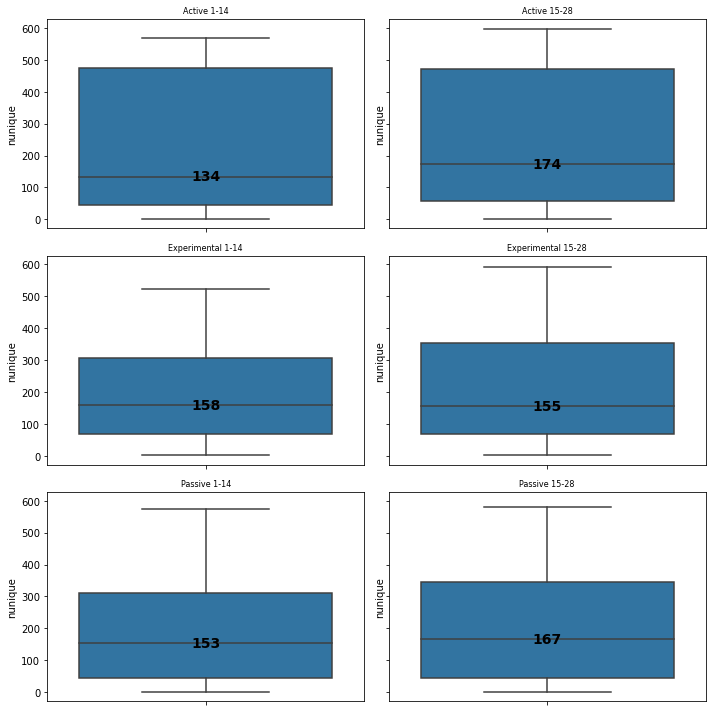

paired t-test for active_control before vs after intervention: t-statistic=-0.85 and p-value=0.40
paired t-test for experimental_condition before vs after intervention: t-statistic=-0.85 and p-value=0.93
paired t-test for passive_control before vs after intervention: t-statistic=-0.85 and p-value=0.91


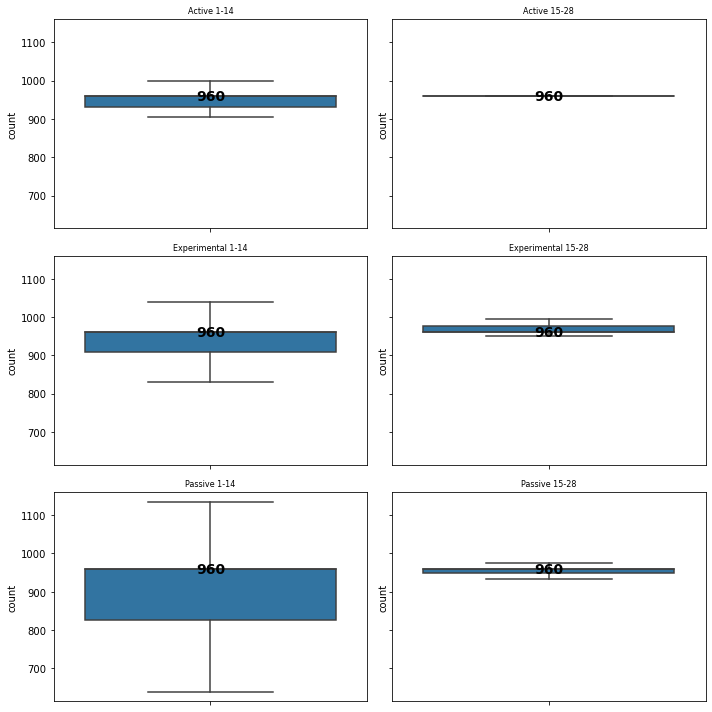

paired t-test for active_control before vs after intervention: t-statistic=1.48 and p-value=0.14
paired t-test for experimental_condition before vs after intervention: t-statistic=1.48 and p-value=0.06
paired t-test for passive_control before vs after intervention: t-statistic=1.48 and p-value=0.66


In [12]:
for clm in my_list:
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
    sns.boxplot(y=active_control_1_14[clm], orient="v", showfliers=False, ax=ax1)
    sns.boxplot(y=active_control_15_28[clm], orient="v", showfliers=False, ax=ax2)
    sns.boxplot(y=experimental_condition_1_14[clm],orient="v", showfliers=False, ax=ax3)
    sns.boxplot(y=experimental_condition_15_28[clm],orient="v", showfliers=False, ax=ax4)
    sns.boxplot(y=passive_control_1_14[clm], orient="v", showfliers=False, ax=ax5)
    sns.boxplot(y=passive_control_15_28[clm], orient="v", showfliers=False, ax=ax6)

    ax1.set_title("Active 1-14", fontsize=8)
    m1 = int(active_control_1_14[clm].median())
    ax1.text(0, m1, m1, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax2.set_title("Active 15-28", fontsize=8)
    m2 = int(active_control_15_28[clm].median())
    ax2.text(0, m2, m2, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax3.set_title("Experimental 1-14", fontsize=8)
    m3 = int(experimental_condition_1_14[clm].median())
    ax3.text(0, m3, m3, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax4.set_title("Experimental 15-28", fontsize=8)
    m4 = int(experimental_condition_15_28[clm].median())
    ax4.text(0, m4, m4, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax5.set_title("Passive 1-14", fontsize=8)
    m5 = int(passive_control_1_14[clm].median())
    ax5.text(0, m5, m5, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax6.set_title("Passive 15-28", fontsize=8)
    m6 = int(passive_control_15_28[clm].median())
    ax6.text(0, m6, m6, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    plt.tight_layout()
    plt.show()

    t, p = stats.ttest_rel(active_control_1_14[clm].iloc[:200], active_control_15_28[clm].iloc[:200])
    print('paired t-test for active_control before vs after intervention: t-statistic={:.2f} and p-value={:.2f}'.format(t, p))
    stat, p = stats.ttest_rel(experimental_condition_1_14[clm].iloc[:200], experimental_condition_15_28[clm].iloc[:200])
    print('paired t-test for experimental_condition before vs after intervention: t-statistic={:.2f} and p-value={:.2f}'.format(t, p))
    stat, p = stats.ttest_rel(passive_control_1_14[clm].iloc[:200], passive_control_15_28[clm].iloc[:200])
    print('paired t-test for passive_control before vs after intervention: t-statistic={:.2f} and p-value={:.2f}'.format(t, p))
